# IPython Notebook: 
## by David Whitney (dwhitneycmu@gmail.com)
Welcome to a tutorial detailing how to connect with Google Finance to acquire recent historical data for all of the stocks listed on the NASDAQ stock exchange. Using this data, we will compare the recent performance of the popular FAANG stocks relative to other NASDAQ stocks. 

But why are FAANG stocks interesting? While thousands of American companies makeup American stock exchanges like the NASDAQ, a recent Wall Street journal article, using data compiled by brokerage firm JonesTrading, stated that just six companies accounted for more than half of the value added to the NASDAQ in 2015: Amazon, Google, Apple, Facebook, and Netflix, and Gilead [1]. Not surprisingly, these six high-performing stocks have received considerable attention from business analysts [1-3]. Jim Cramer from Mad Money even went so far to dub four of these fast-growing NASDAQ stocks (Facebook, Amazon, Netflix, and Google) with the acronym ‘FANG’ to emphasize the privileged position that these companies enjoy [3]. Because the precise definition of ‘FANG’ leaves out Apple and Gilead, the six major companies that serve as this tutorial's focus will be denoted here by the slightly longer acronym ‘FAANG.’

Because so much recent growth in the NASDAQ composite index is attributable to growth by the six FAANG stocks, I wondered whether the market rebound from the Great Recession of 2008 implies the success story of a few thriving companies, or is instead reflected in a broad advance by most American companies. Thus, in this Ipython notebook, we will investigate whether FAANG stocks more consistently grow than other NASDAQ stocks, and if they more accurately predict market swings in the NASDAQ.

**References**:
* [1] D. Strumpf. Wall Street Journal. “The Only Six Stocks That Matter”. http://www.wsj.com/articles/the-only-six-stocks-that-matter-1437942926  (July 26, 2015).
* [2] A. Mirhaydari. CBS Moneywatch. “Uh oh -- just 8 stocks are propping up the market”. http://www.cbsnews.com/news/uh-oh-just-8-stocks-are-propping-up-the-market/ (November 12, 2005)
* [3] C. Ciaccia. “What Are FANG Stocks and Why Does Jim Cramer Love Them?”. https://www.thestreet.com/story/13230576/1/what-are-fang-stocks-and-why-does-jim-cramer-love-them.html (July 24, 2015) 

In [1]:
# Import some useful packages that we will need
import datetime
import matplotlib as plt
import numpy as np
import os 
import pandas as pd
import pickle
import sklearn.linear_model
from copy import deepcopy
from scipy import signal
from stockDataObject import stockDataObject, showScatterPlot

# Setup Matplotlib
%matplotlib inline
plt.rcParams['font.family'] = 'Arial';#'DejaVu Sans';
plt.rcParams['pdf.fonttype'] = 42
plt.rc('font', serif='Arial') 
plt.rc('text', usetex='false')#, dvipnghack ='True', hinting='native') 
plt.rc('mathtext', fontset='custom'); #valid strings are [u'custom', u'stix', u'cm', u'stixsans']

### Connect with Google Finance and download historical information on all NASDAQ stocks: 
First, we'll setup an instance of our stockDataObject, which contains all the data and methods needed for this iPython tutorial. When initializing the object, the class constructor will by default interact with Google Finance's API to iteratively download historical data for the daily adjusted closing stock-price of all current NASDAQ stocks (Jan. 1, 2011 - Jan 1., 2017). The listing of NASDAQ stocks was obtained directly from NASDAQ.com, and includes only companies listed on the NASDAQ exchange as of January 2017 [4]. Within the stockDataObject, all historical data is saved within a Pandas dataFrame object named 'stockData'. The dimensions of the Pandas dataFrame are (t,n), where t is the business day and n is the NASDAQ stock. The stocks are ordered such that the first element is the NASDAQ composite index itself (^IXIC), followed by the FAANG stocks, then other Top-100 NASDAQ stocks, and finally by all other NASDAQ stocks.

[4] A current listing of NASDAQ companies: http://www.nasdaq.com/screening/companies-by-name.aspx?letter=0&exchange=nasdaq&render=download

In [2]:
baseDirectory     = os.getcwd(); # Where to save stock information
reloadRAWData     = False;       # If true, gathers raw data from Google or Yahoo finance; else loads saved data from a previous iteration
recomputeAnalysis = True;        # If true, recomputes all analyses, else reloads a previous iteration of analyses (to save time)
if reloadRAWData:
    # Chose loading parameters
    startDate = datetime.datetime(2011, 1, 1); # Specifies start date for historical stock data
    endDate   = datetime.datetime(2017, 1, 1); # Specifies ending date for historical stock data
    stockPriceType  = 'Close';                 # Specifies stock metric to use - can be either [Open, High, Low, Close, Volume]
    
    # Initialize stockDataObject, and read recent historical data for NASDAQ stocks from Google Finance
    projectData = stockDataObject(startDate=startDate, endDate=endDate, stockPriceType=stockPriceType);
    
    # Write stock data to file
    projectData.saveData(saveDirectory=baseDirectory);
else:
    projectData = stockDataObject(stockData=pd.DataFrame([]));
    projectData.loadData(saveDirectory=baseDirectory);

### Pre-processing the raw historical data:
Before moving on to the actual analysis, we need to perform some data pre-processing. First, I made a strategic decision only to include stocks in the analysis that were listed on the NASDAQ for at least one business year. The rationale behind this decision was to focus on stocks most likely to have contributed to market growth over the last six years. Fortunately, only 45 of 3,130 NASDAQ stocks were excluded based upon this loose criterion.

Furthermore, changes in the adjusted stock price are not comparable between stocks, since stock valuations vary considerably. What normalization options do we have? Perhaps the most straightforward option is just to compute the relative growth in stock price since 2011. Another option would be to z-score the historical data for each stock. While computing the relative change in stock price explicitly quantifies actual growth, the z-score affords the opportunity to look at the general shape/trend of growth for each company. Z-scoring also ensures that when computing summary statistics across multiple companies, a single company cannot dominate the group average. However, for the purposes of this tutorial, we will consider both normalization metrics, as both metrics have their strengths and weakness. For comparing actual growth, we'll use the relative change in stock price, but for the regression analysis we'll be using the z-score.

Lastly in terms of understanding how well individual stocks co-vary with the market, we cannot directly correlate historical stock prices with the NASDAQ index. Indeed the market and historical stock prices could only be loosely coupled on a day-to-day basis, while still showing the same long-term trend of growth. Thus, if a true correlative relationship exists, then day-to-day fluctuations in market value and stock prices need to be correlated. 

In [3]:
# Normalization based on the relative change in stock price
if recomputeAnalysis:
    relativeChangeData = deepcopy(projectData);
    relativeChangeData.preProcessStockData(zScoreData=False,eliminateStocksLessThanAYear=True); # Z-score data (or use relative change from starting day), and then eliminate stocks which have less than 1 year of data
    relativeChangeData.stockData.iloc[:,(relativeChangeData.stockData.max(axis=0)>5000).values]=np.nan; # We eliminate stocks that have growth increases greater than 50 (i.e. 5000%)
    relativeChangeData.computeDayToDayDifferences();
    pickle.dump(relativeChangeData, open(baseDirectory+"\\relativeChangeDataObject.p", "wb"));
    
    # Normalization based on the z-scored stock price
    zscoredData = deepcopy(projectData);
    zscoredData.preProcessStockData(zScoreData=True,eliminateStocksLessThanAYear=True); # Z-Score data (or use relative change from starting day), and then eliminate stocks which have less than 1 year of data
    zscoredData.computeDayToDayDifferences();
    pickle.dump(zscoredData, open(baseDirectory+"\\zscoredDataObject.p", "wb"));
else:
    relativeChangeData = pickle.load(open(baseDirectory+"\\relativeChangeDataObject.p", "rb"));
    zscoredData        = pickle.load(open(baseDirectory+"\\zscoredDataObject.p", "rb"));

# Recent growth in FAANG stocks:
Now that we have loaded the historical stock data into Python and performed some basic pre-processing, what kind of growth have the FAANG stocks recently enjoyed? Let’s look at a summary stock chart for the performance of FAANG stocks from 2011 to 2017. To illustrate how our two different normalization metrics provide different pictures of the data (see the previous section on relative change and z-scoring), we'll loop through them both. For each normalization metric, we'll plot the average annual growth rate. Also, we will plot the correlation between the day-to-day fluctuations in FAANG stocks with the NASDAQ, which is unaffected by the normalization.

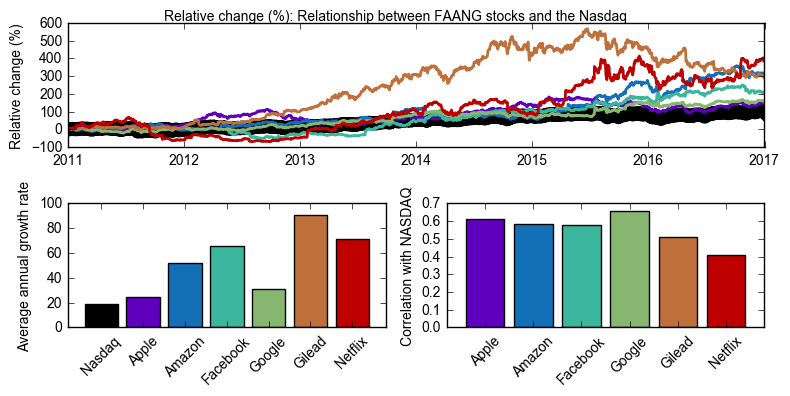

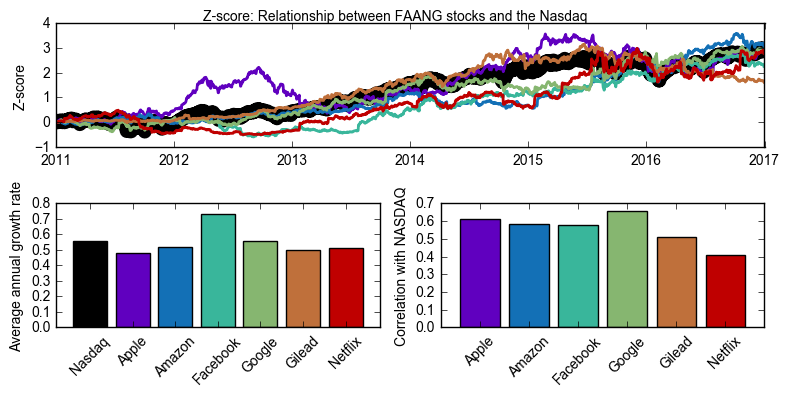

In [9]:
dataObjects = [relativeChangeData,zscoredData];
yLabels = ['Relative change (%)','Z-score'];
for (dataObject,yLabel) in zip(dataObjects,yLabels):
    dataObject.summarizeRelationshipWithNASDAQ(stockLabels = ['Nasdaq','Apple','Amazon','Facebook','Google','Gilead','Netflix'],figSize=(8,4),title=yLabel+': Relationship between FAANG stocks and the Nasdaq',yLabel=yLabel)

We can immediately see from these plots that all of the FAANG stocks have consistently grown during this period. Furthermore, day-to-day stock fluctuations consistently covaried with day-to-day market changes in the NASDAQ. These positive indicators strongly imply that recent market growth could be principally attributed to FAANG stocks. Also, it's worth pointing out that the two different normalization approaches provide different pictures of growth. While the absolute rate of growth varies between FAANG stocks (see the relative change plot), all of the FAANG stocks have consistently grown (see the z-scored plot).

### Comparing the growth of FAANG stocks relative to other NASDAQ stocks:
While FAANG stocks have been robustly growing over the last six years, what about other NASDAQ stocks? The NASDAQ composite index is currently comprised of roughly 3,100+ American companies. And some of the largest and most influential of these companies, including FAANG, are listed on the NASDAQ-100 Index. Do other large companies associated with the Top-100 NASDAQ Index exhibit similar growth rates to the popular FAANG stocks? Moreover, what about the recent performance of the larger bulk of ~3000 NASDAQ stocks not associated with either the FAANG or Top-100 NASDAQ stocks? Here in this section, we compare the growth of FAANG stocks (n=6) relative to the larger backdrop of NASDAQ stocks, which includes:
* the NASDAQ composite index (n=1)
* other Top-100 NASDAQ stocks (n=95). 
* all other ordinary NASDAQ stocks (n=2,982), as well as breaking this large group into two smaller subgroups: a.) the top 20% growing stocks (n=555), and b.) the bottom 80% growing stocks (n=2,216). The rationale here is to test whether the best growing NASDAQ stocks, not associated with the Top-100, display growth rates comparable to the FAANG stocks.  

To get a qualitative picture of the growth observed within each group over the last six years, we plot the mean relative change in stock price for each group. In this plot, the solid lines indicate the mean relative change in stock price, while the shaded areas indicate the 95th confidence intervals. The color of the line indicates the stock group: NASDAQ (black), FAANG (red), other Top-100 NASDAQ (blue), other ordinary NASDAQ stocks (green), the top 20% growing ordinary NASDAQ stocks (yellow), and the bottom 80% growing ordinary stocks (purple).

Furthermore, to quantitatively assess significant differences between groups, we compute the annual growth rate for every stock and determine if there are systematic differences between groups. This quantification is plotted in two different ways: 1.) a cumulative probability plot highlighting the full distribution of growth present within each group and 2.) a bar plot showing the mean annual growth rate in each stock group, plus error bars (SEM). Statistical differences are assessed with the Mann Whitney U test, and p-values are shown directly on the bar plot and in table-form.

stockDataObject.py:564: RankWarning: Polyfit may be poorly conditioned
  p = np.polyfit(t[validData],stockData[stock][validData].values,1);


Average annual growth rate (Mean +/- SEM across stocks):
--------------------------------------------------------
NASDAQ - 19.3518004552 +/- 0.0 (SEM)
FAANG stocks - 55.850223841 +/- 9.3873687055 (SEM)
Other Top 100 NASDAQ stocks - 26.3334182559 +/- 3.85961719437 (SEM)
Other NASDAQ stocks (All) - 9.22647384337 +/- 1.05243209792 (SEM)
Other NASDAQ stocks (Bottom 80%) - -4.9353630996 +/- 0.456844584866 (SEM)
Other NASDAQ stocks (Top 20%) - 65.8738216153 +/- 4.13808163273 (SEM)
--------------------------------------------------------
Testing significance of differences between stock groups (Mann Whitney U Test): 
             FAANG  Top 100   Other  Bottom 80%  Top 20%
FAANG       1.0000   0.0101  0.0029         0.0   0.5119
Top 100     0.0101   0.9989  0.0000         0.0   0.0000
Other       0.0029   0.0000  0.9953         0.0   0.0000
Bottom 80%  0.0000   0.0000  0.0000         1.0   0.0000
Top 20%     0.5119   0.0000  0.0000         0.0   1.0000


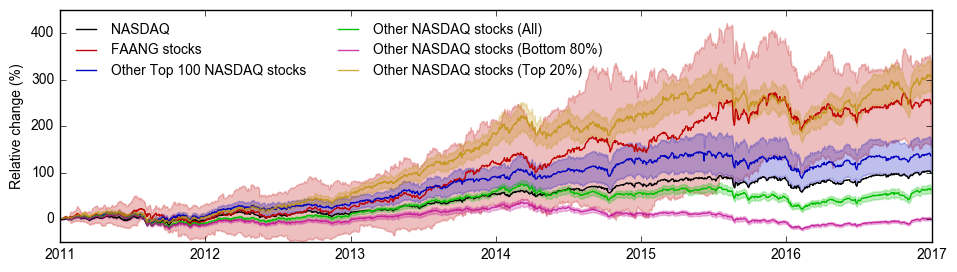

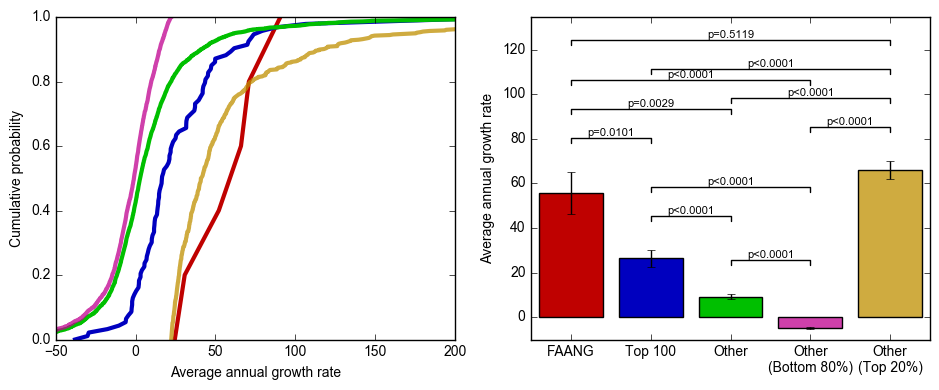

In [5]:
# Compute the average annual growth rate
if recomputeAnalysis:
    slopeData = relativeChangeData.computeSlope();
    slopeData.to_csv(baseDirectory+'\stockSlopeValues.csv')
else:
    slopeData = pd.Series.from_csv(baseDirectory+'\stockSlopeValues.csv');

# Show a historical chart of the mean relative change across each of the six stock groups
relativeChangeData.showHistoricalCharts(figSize=(11.25,3),yLabel=yLabels[0], \
                                        xLimits=[relativeChangeData.startDate,relativeChangeData.endDate],yLimits=[-50,450])    
    
# Show some quantification of the average annual growth for the different stocks groups:
print "Average annual growth rate (Mean +/- SEM across stocks):"
print "--------------------------------------------------------"
relativeChangeData.showCumulativeProbabilityAndBarPlot(slopeData,xLimits=[-50,200],xLabel='Average annual growth rate',skipMarket=False,figSize=(9.5,4))

From the above plots, we can see that FAANG stocks greatly outperform most ordinary NASDAQ stocks, and even display higher growth than other Top-100 stocks. But interestingly, the top 20% growing ordinary NASDAQ stocks show statistically indistinguishable growth rates to the FAANG stocks. These results unequivocally demonstrate that while FAANG stocks consistently perform well, they are not unique sanctuaries of growth. In fact, the analysis indicates that a much larger subset of NASDAQ stocks robustly grows at rates roughly comparable (or greater) to FAANG stocks. For investors seeking portfolio diversification this is welcome news.

# Do FAANG stocks better predict market movements?
Here we need different analytics to address the second posed question whether the NASDAQ’s movements are better explained by day-to-day fluctuations in stock price by FAANG companies versus other NASDAQ companies. As many thousands of stocks comprise the NASDAQ, we have little reason to expect that stocks, even when they are equally correlated with the NASDAQ, will drive market growth equivalently. For instance, the market capitalization of stocks is lopsided, where FAANG and other NASDAQ-100 stocks respectively make up ~25% and ~35% of the NASDAQ’s market value. These numbers suggest that larger cap stocks might have a disproportionately larger influence on NASDAQ growth. 

Let's investigate whether this hypothesis is true. First, we'll compare whether day-to-day fluctuations in the NASDAQ are more correlated with day-to-day fluctuations in FAANG stocks than other NASDAQ stocks. 

Correlation between day-to-day differences in stock and market value (Mean +/- SEM across stocks):
--------------------------------------------------------
FAANG stocks - 0.559549956268 +/- 0.0331772300615 (SEM)
Other Top 100 NASDAQ stocks - 0.529776424427 +/- 0.0113001023687 (SEM)
Other NASDAQ stocks (All) - 0.292877006947 +/- 0.00391761461335 (SEM)
Other NASDAQ stocks (Bottom 80%) - 0.289043169601 +/- 0.00452829196466 (SEM)
Other NASDAQ stocks (Top 20%) - 0.318483721503 +/- 0.007681183125 (SEM)
--------------------------------------------------------
Testing significance of differences between stock groups (Mann Whitney U Test): 
             FAANG  Top 100   Other  Bottom 80%  Top 20%
FAANG       1.0000   0.5367  0.0048      0.0013   0.0009
Top 100     0.5367   0.9989  0.0000      0.0000   0.0000
Other       0.0048   0.0000  0.9977      0.0000   0.2151
Bottom 80%  0.0013   0.0000  0.0000      1.0000   0.0000
Top 20%     0.0009   0.0000  0.2147      0.0000   0.9999


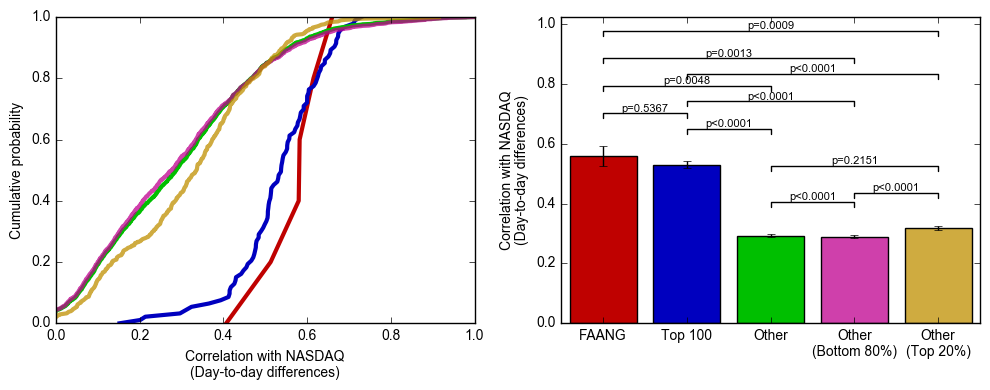

In [10]:
# Show some quantification of the correlation between day-to-day differences in stock and market value:
print "Correlation between day-to-day differences in stock and market value (Mean +/- SEM across stocks):"
print "--------------------------------------------------------"
dayToDayDifference = zscoredData.computeDayToDayDifferences();
correlationValues = zscoredData.computeCorrelationsWithMarket(dayToDayDifference);
relativeChangeData.showCumulativeProbabilityAndBarPlot(correlationValues,xLimits=[0,1],xLabel='Correlation with NASDAQ\n(Day-to-day differences)')

And the answer is yes! Top-100 NASDAQ stocks, including the FAANG stocks, show more correlated fluctuations with the market than other NASDAQ stocks. And this even includes the top 20% growing ordinary NASDAQ stocks. Indeed this might suggest market cap value is an important predictor in determining whether day-to-day fluctuations in a stock's price are evident in market swings of the NASDAQ composite index. To determine if this is true, we'll look at the breakdown of market cap value based on our five groups, and then assess if there is a relationship between a stock's market cap value and correlation with the NASDAQ.

FAANG stocks - 11.4598798369 +/- 0.170186360693 (SEM)
Other Top 100 NASDAQ stocks - 10.4469757843 +/- 0.0404275665464 (SEM)
Other NASDAQ stocks (All) - 8.45220037359 +/- 0.0168994085618 (SEM)
Other NASDAQ stocks (Bottom 80%) - 8.34405002703 +/- 0.0190920553626 (SEM)
Other NASDAQ stocks (Top 20%) - 8.90343564565 +/- 0.030532146332 (SEM)
--------------------------------------------------------
Testing significance of differences between stock groups (Mann Whitney U Test): 
             FAANG  Top 100   Other  Bottom 80%  Top 20%
FAANG       1.0000   0.0008  0.0081      0.0031    0.001
Top 100     0.0008   0.9958  0.0000      0.0000    0.000
Other       0.0081   0.0000  0.8427      0.0000    0.000
Bottom 80%  0.0031   0.0000  0.0000      0.8069    0.000
Top 20%     0.0010   0.0000  0.0000      0.0000    0.934


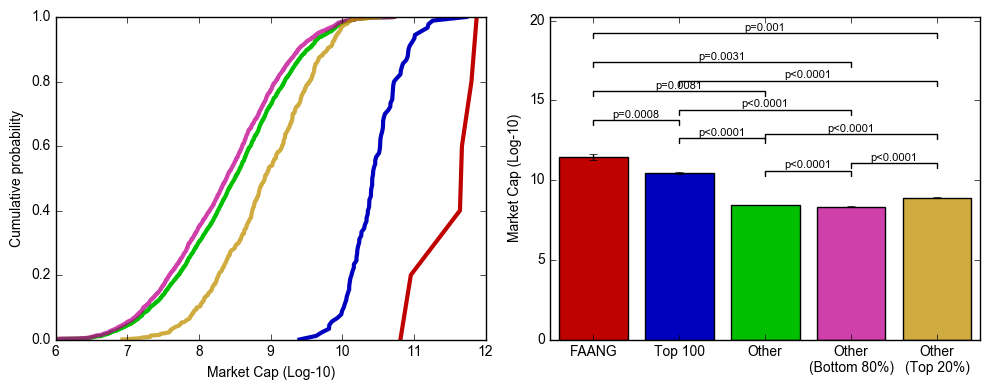

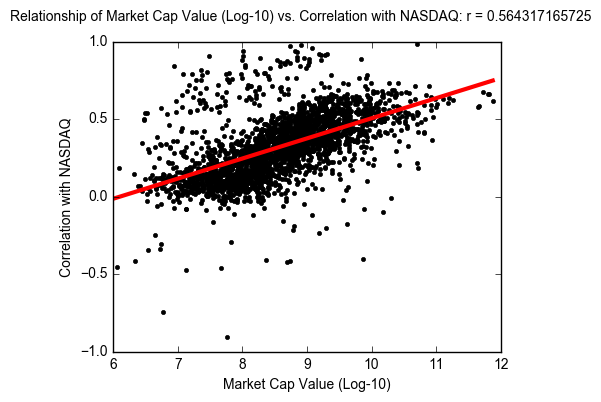

In [7]:
# Connect with NASDAQ.com and read in current market cap data for 2017
if recomputeAnalysis:
    marketCapData = relativeChangeData.readMarketCapData(isVerbose=False);
    marketCapData.to_csv(baseDirectory+'\marketCapValues.csv')
else:
    marketCapData = pd.Series.from_csv(baseDirectory+'\marketCapValues.csv');

# Convert raw market cap value in dollars to a logarithmic scale (since market cap values widely range from millions to billions)
normalizedMarketCapData = np.log10(marketCapData);
normalizedMarketCapData[np.isfinite(normalizedMarketCapData)==False] = np.nan;

# Market cap breakdown in each stock group
zscoredData.showCumulativeProbabilityAndBarPlot(normalizedMarketCapData,xLabel='Market Cap (Log-10)',xLimits=[6,12])

# Relationship between market cap value and correlation with the NASDAQ
fig = showScatterPlot(normalizedMarketCapData,correlationValues, \
                      xTitle='Market Cap Value (Log-10)',yTitle='Correlation with NASDAQ',title='', \
                      xLimits=[6,12],yLimits=[-1,1])

We can see a clear connection between a stock’s market cap value and correlation with the NASDAQ (r = 0.56) indicating that larger-cap stocks are better market predictors. However, there are some shortcomings with the above correlation-based analysis. Correlation is computed iteratively and assesses the relationship of a single stock with the NASDAQ. As mentioned earlier, we have little reason to expect that stocks, even when they are equally correlated with the NASDAQ, will drive market growth equivalently. Thus, we need to take a multivariate approach that considers all stocks at once. To do this, I setup a Ridge regression model where the input features are the day-to-day fluctuations in z-scored stock data for the 3,000+ NASDAQ stocks with the goal of predicting day-to-day changes in the NASDAQ. 

The model was independently trained using 5-fold cross-validation on three different time-scales: short interval (2 weeks), quarterly (13 weeks), and annual (52 weeks). In this six-year dataset, there are 156 short training intervals, 24 quarterly intervals, and 6 annual intervals. Each training period results in a unique weighting coefficient for every stock. A higher weighting coefficient intuitively indicates that a stock better predicts market movements relative to other stocks during that training period. To summarize how well every stock nominally predicted the NASDAQ’s movements in each of the different time-scales, we can then compute a median weighting coefficient across all weighting coefficients for each of the three time-scales. For example, for the quarterly training interval, we would compute the median coefficient across the 24 quarterly-computed weighting coefficients.

Regression analysis (Mean +/- SEM across stocks):

--------------------------------------------------------
TRAINING PERIOD FOR REGRESSION ANALYSIS: 2 Weeks
FAANG stocks - 1.87756953032 +/- 0.239876631286 (SEM)
Other Top 100 NASDAQ stocks - 2.29580059449 +/- 0.100197718006 (SEM)
Other NASDAQ stocks (All) - 1.20424597509 +/- 0.0205938413352 (SEM)
Other NASDAQ stocks (Bottom 80%) - 1.35695848853 +/- 0.0255547020564 (SEM)
Other NASDAQ stocks (Top 20%) - 1.01215829301 +/- 0.025938599904 (SEM)
--------------------------------------------------------
Testing significance of differences between stock groups (Mann Whitney U Test): 
             FAANG  Top 100   Other  Bottom 80%  Top 20%
FAANG       1.0000   0.2166  0.0381      0.1012   0.0027
Top 100     0.2166   1.0000  0.0000      0.0000   0.0000
Other       0.0381   0.0000  1.0000      0.0000   0.3309
Bottom 80%  0.1012   0.0000  0.0000      1.0000   0.0000
Top 20%     0.0027   0.0000  0.3309      0.0000   1.0000

-------------------------

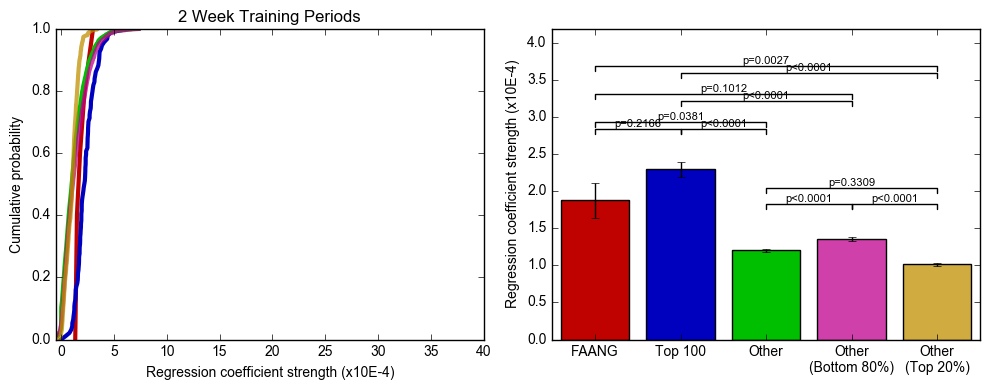

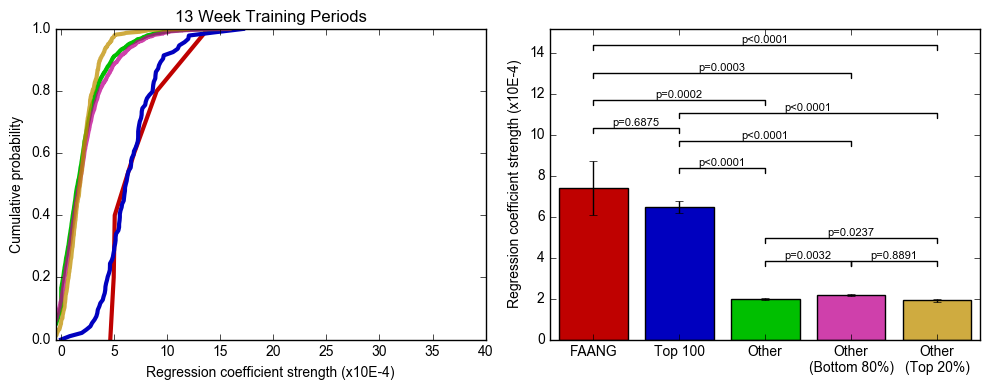

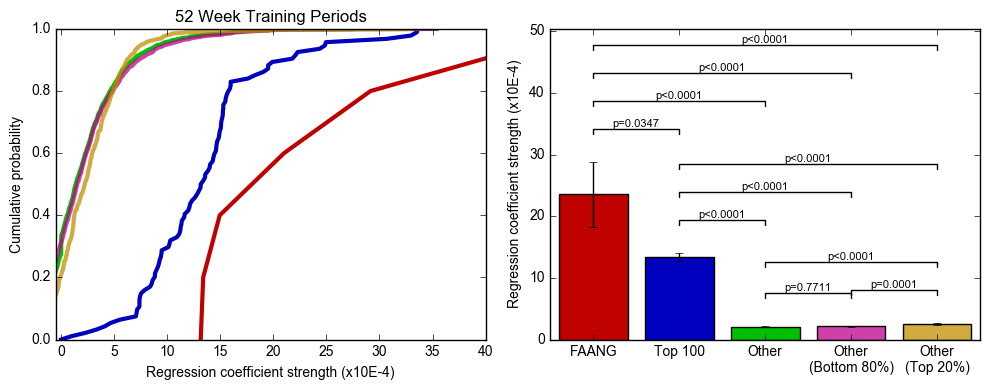

In [8]:
# Show some quantification of the regression coefficients for the different stocks groups:
print "Regression analysis (Mean +/- SEM across stocks):"
stockSet = 'AllStocks';
clf = sklearn.linear_model.RidgeCV(fit_intercept=False,cv=5); # Linear model will be Ridge Regression with 5-fold cross-validation
regressionCoefficientsTables = [];
for trainingInterval in [2,13,52]: # in weeks
    (regressionCoeffs, correlationCoeffs) = zscoredData.computeRegressionCoefficients(stockData=zscoredData.stockData_dayToDayDifference.fillna(0),stockSet=stockSet,clf=clf,binningIntervals=[trainingInterval],skipCorrelations=True,usePCA=False,timeIntervalType='W')
    regressionCoefficientsTable = pd.Series(np.zeros([zscoredData.numberOfStocks]),index=zscoredData.listOfStocks);
    regressionCoefficientsTable.iloc[zscoredData.getSequenceOfStocks(stockSet)]=regressionCoeffs.mean(axis=0).fillna(0);
    regressionCoefficientsTables.append({'trainingInterval':trainingInterval,'regressionCoefficientsTable':regressionCoefficientsTable*1E4})
    
    print('\n--------------------------------------------------------');
    print('TRAINING PERIOD FOR REGRESSION ANALYSIS: {} Weeks'.format(trainingInterval));
    zscoredData.showCumulativeProbabilityAndBarPlot(regressionCoefficientsTable*1E4,xLabel='Regression coefficient strength (x10E-4)',xLimits=[-0.5,40],title="{} Week Training Periods".format(trainingInterval))

What does this analysis suggest? First, the FAANG and Top 100 Nasdaq stocks have consistently higher regression coefficients than other NASDAQ stocks. This means the Top-100 NASDAQ stocks do better predict market swings in the NASDAQ. However, on short time intervals of 2 weeks, regression coefficients are universally smaller and therefore more broadly distributed across all stocks. This suggest that on shorter time-scales, the larger cap stocks more weakly predict market movements. 

But as the training interval increases, both FAANG and Top-100 stocks more strongly predict the NASDAQ. Provocatively we find that at time-scales of around a year, FAANG stocks more strongly predict market movements as a group than even other Top-100 stocks. Thus, we can conclude that on longer time-scales, FAANG stocks do better predict market movements.

# CONCLUSIONS
In summary, we’ve taken advantage of the analytical framework developed here to apply basic data science principles to investigate the recent performance of FAANG stocks, including their impact on the stock market. While the analyses confirm FAANG stocks are attractive investments, they are not singular investment opportunities. In fact, we found that 20% of NASDAQ stocks show growth rates matching or exceeding that of the FAANG stocks. Thus, if an investor is willing to do the research, he/she is likely to be able to search for a set of stocks that outperforms these FAANG stocks. 

Thanks for taking the time to go through this Ipython tutorial. I hope the code examples and analytic framework developed here is of use to others interested in developing quantitative tools for investing. Any comments or suggestions would be welcome. And happy investing!